In [127]:
%load_ext autoreload
%autoreload 2

# standard
import sys
import os

# env specific
import numpy as np
import scipy.linalg as linalg
import cv2

import matplotlib.pyplot as plt
from matplotlib import rcParams

# custom
sys.path.append('e:\\Dropbox\\py_projects\\signal\\signal')
# print(sys.path)
import src.signallib as sl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
titlefont = 'Gill Sans MT'
mainfont = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [mainfont, titlefont]

rcParams['figure.facecolor'] = 'white'
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlesize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Data Partition
Split images into train, validation, and test sets

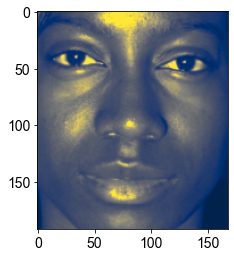

In [131]:
face = 'yaleB22'
image_filepath = f'E:/CroppedYale/{face}/'
image_filename = f'{face}_P00_Ambient.pgm'
image_filename = f'{face}_P00A+005E-10.pgm'

img_test = cv2.imread( image_filepath+image_filename, -1)

plt.imshow(img_test, cmap='cividis')

In [140]:
type(img_test[1,1])

numpy.uint8

In [161]:
image_filepath = f'E:/CroppedYale/'
# each folder contains images for one model
image_keys = [ s[-2:] for s in os.listdir(image_filepath) ]
# all folders have this prefix
image_key_filepath_prefix = 'yaleB'

# init RNG
rng = np.random.default_rng(seed=7)
# init train, valid, test file names lists
train_fns = {}
valid_fns = {}
test_fns = {}
# how many images in validation and test sets per model
nvalid_per_key = 2
ntest_per_key = 1

# create lists of filenames for each set
for k in image_keys:
   # fns in model folder
   fns = os.listdir(image_filepath+image_key_filepath_prefix+k)
   # ambient is sometimes not useful, discard non-PGM files
   fns = [fn for fn in fns if ('.pgm' in fn)&('Ambient' not in fn)]
   
   nfns = len(fns)
   # shuffle the image names
   fns_permute = rng.choice(nfns, nfns, replace=False)

   # select image names for each data set
   train_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[:-(nvalid_per_key+ntest_per_key)]
               ]
   valid_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i
                  in fns_permute[-(nvalid_per_key+ntest_per_key):-ntest_per_key] 
               ]
   test_fns[k] = [ image_key_filepath_prefix + k + '/' + fns[i] 
                  for i 
                  in fns_permute[-ntest_per_key:]
               ]
    

## Load and Reshape Training Data

In [354]:
def load_img_vector( filepath, meanvec=None ):
    img = cv2.imread( filepath, flags=cv2.IMREAD_GRAYSCALE)
    imgvec = np.reshape(img, (-1, ))
    if meanvec is not None:
        imgvec = imgvec - meanvec
    return imgvec

# base path to images
image_filepath = f'E:/CroppedYale/'

# rows and columns of the images
NROWS = 192
NCOLS = 168
# number of training images
NTRAIN = len(train_fns)*len(train_fns['01'])

# init X matrix
train_X = np.zeros([NROWS*NCOLS, NTRAIN], dtype=np.uint8)
i = 0
for key, fns in train_fns.items():
    for fn in fns:
        imgvec = load_img_vector( image_filepath+fn )
        train_X[:,i] = imgvec
        i += 1

train_X_mean = train_X.mean(axis=1, keepdims=True)
train_meanvec = np.reshape(train_X_mean, (-1,)) # reshape
train_X_std = train_X.std(axis=1, keepdims=True)

train_X_meansub = (train_X - train_X_mean) 
train_X_norm = (train_X - train_X_mean) / train_X_std

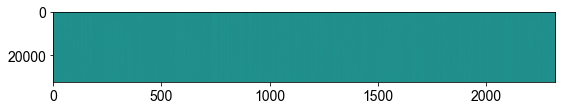

In [337]:
fig,ax = plt.subplots(figsize=(9,12))
ax.imshow(train_X_norm, aspect=0.01, vmin=-128, vmax=128)

In [305]:
train_X.max()
# train_X_meansub.min()

255

## SVD

In [338]:
# umat, svals, vmat = linalg.svd( train_X, full_matrices=False, check_finite=False)
umat, svals, vmat = linalg.svd( train_X_meansub, full_matrices=False, check_finite=False)
# umat, svals, vmat = linalg.svd( train_X_norm, full_matrices=False, check_finite=False)

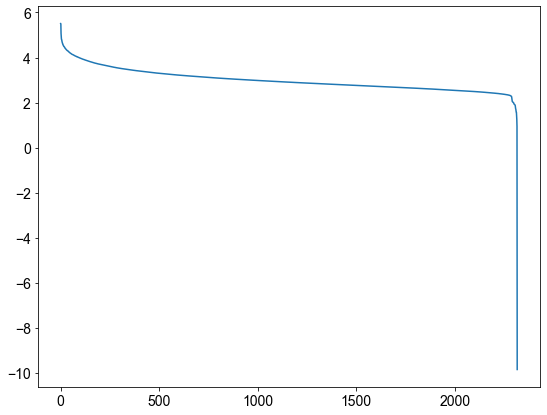

In [339]:
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(np.log10(svals))

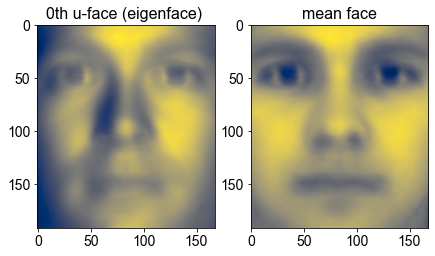

In [340]:
nu = 0
img_uface = np.reshape(umat[:,nu], [NROWS, NCOLS])
img_meanface = np.reshape(train_X_mean, [NROWS, NCOLS])
fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(7,7))
cmapname = 'cividis'
ax0.imshow(img_uface, cmap=cmapname)
ax1.imshow(img_meanface, cmap=cmapname)
ax0.set_title(f'{nu}th u-face (eigenface) ')
ax1.set_title(f'mean face')
plt.show()

## Project onto u-space

In [385]:
# number of SVD vectors in dimension reduced U-space
N_UVEC = 1000
umat_reduced = umat[:, :N_UVEC]

key_projections = {}

for key, fns in train_fns.items():
    # cols are projections of fn onto u-vectors
    uproj = np.zeros([ N_UVEC, len(fns)])

    for i,fn in enumerate(fns):
        imgvec = load_img_vector(image_filepath+fn, meanvec=train_meanvec)
        
        uproj_fn = np.transpose(umat_reduced) @ imgvec

        uproj[:,i] = uproj_fn
    
    key_projections[key] = uproj


In [386]:
imgvec.shape

(32256,)

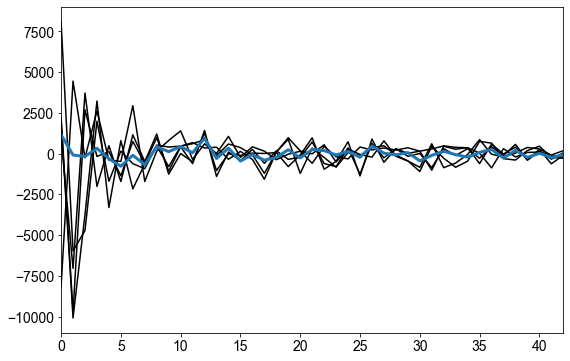

In [387]:
keytemp = '01'
fig,ax = plt.subplots(figsize=(9,6))
nimg = key_projections[keytemp].shape[1]

umean = key_projections[keytemp].mean(axis=1)
ax.plot(umean, linewidth=3, zorder=1)
for i in range(5):
    ax.plot(key_projections[keytemp][:,i], color='k', linewidth=1.5, zorder=0)
ax.set_xlim([0,42])
# ax.set_ylim([-1000,1000])
plt.show()

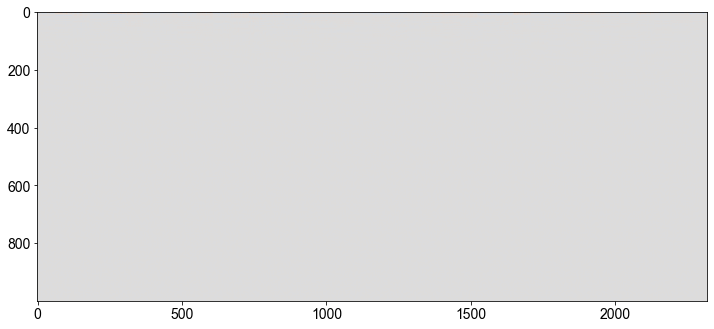

In [393]:
fig,ax = plt.subplots(figsize=(12,12))
train_projection = np.transpose(umat_reduced) @ train_X_meansub
# plt.imshow(train_projection[:22,:64], aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)
plt.imshow(train_projection, aspect=1, cmap='coolwarm', vmin=-1.5e4,vmax=1.5e4)

In [389]:
# average projection of key onto u-space
NKEYS = len(image_keys)
key_projections_u_mean = np.zeros([NKEYS, N_UVEC])
for i,(key,proj) in enumerate(key_projections.items()):
    # print(i)
    key_projections_u_mean[i,:] = proj.mean(axis=1)

    

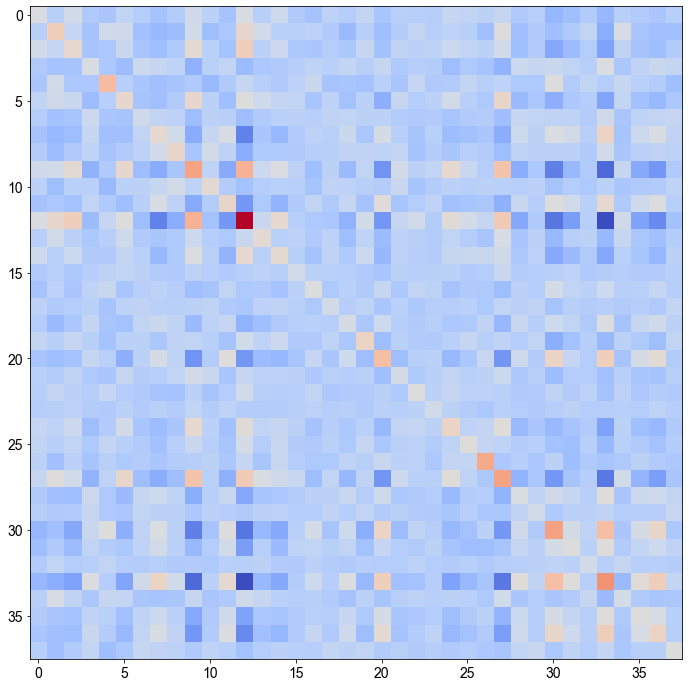

In [390]:
fig,ax = plt.subplots(figsize=(12,12))

plt.imshow(key_projections_u_mean @ np.transpose(key_projections_u_mean) , aspect=1, cmap='coolwarm',  interpolation='none')
# plt.imshow(np.transpose(key_projections_u_mean[:,:]), aspect=1, cmap='coolwarm', vmin=-5e3,vmax=5e3, interpolation='none')

In [399]:
def softmax( zvec ):
    """
    Boltzman distribution for the values of the zvec.
    """
    Z = np.sum(np.exp(zvec))
    return np.exp(zvec) / Z

def img_class_prob( imgvec, umat_reduced, key_project_mean ):

    imgvec_proj = np.transpose(umat_reduced) @ imgvec
    normconst_imgvec_proj = np.sqrt(imgvec_proj @ imgvec_proj)
    normconstvec_key_proj = (key_project_mean @ np.transpose(key_project_mean)).diagonal()
    normconstvec_key_proj = np.sqrt(normconstvec_key_proj)
    # print(normconstvec_key_proj)
    imgvec_proj_overlap = (key_project_mean @ imgvec_proj)  / (normconstvec_key_proj * normconst_imgvec_proj)
    # imgvec_probability = imgvec_proj_overlap
    imgvec_probability = softmax( imgvec_proj_overlap )
    return imgvec_probability



[0.0340698  0.02429857 0.02966029 0.02673734 0.02227737 0.02924296
 0.02424298 0.02857934 0.03150123 0.02913576 0.03400009 0.02685775
 0.02449769 0.02554833 0.02532732 0.02165609 0.02315543 0.02994989
 0.02308692 0.02558005 0.02574663 0.02705195 0.02462736 0.03183979
 0.02759973 0.02899558 0.01847304 0.02585667 0.0229401  0.0262379
 0.02329139 0.0211288  0.0270734  0.02605873 0.02535847 0.02377542
 0.02858702 0.0259528 ]
1.0


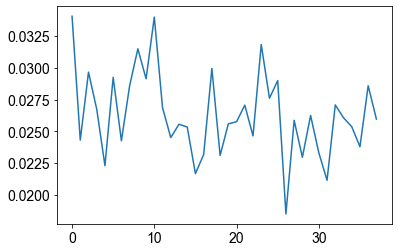

In [400]:
keytemp = '01'
fnindextemp = 3
imgvec1 = load_img_vector(image_filepath+train_fns[keytemp][fnindextemp], meanvec=train_meanvec)
img_prob = img_class_prob( imgvec1, umat_reduced, key_projections_u_mean )
print(img_prob)
print(img_prob.sum())
plt.plot(img_prob)